# Beta distributions on election data 

In this lab you will be looking at [election data taken from Andrew Gelman's book on Bayesian statistics](http://www.stat.columbia.edu/~gelman/arm/examples/election88/) (highly recommended!).

---

## Dataset

The initial parsing code for the data has been completed to save you time so you can get to the Bayesian stuff. You are still required to perform some feature engineering though.

The data contains polling information for George H.W. Bush as well as election information. 

The polling information indicates samples by state of who intends to vote for Bush or not. The voting information is a sample after the election asking who actually voted for bush or not.

---

## 1. Import and parse the data

This portion is done for you. There are two datasets:

    election88  :  this contains the election voting poll information
    pre_poll    :  this contains the pre-election voting poll information

In [132]:
import pandas as pd
import numpy as np

election88 = pd.read_csv('./datasets/election88.csv')

election88.rename(columns={'stnum':'state_id','samplesize':'vote_total'}, inplace=True)

election88 = election88[~election88.st.isin(['DC','AK','HI'])]

print election88.head(3)

   state_id  st  electionresult  vote_total    raking  _merge
0         1  AL            0.59         203  0.673067       3
2         3  AZ            0.60         194  0.568980       3
3         4  AR            0.56         121  0.563672       3


In [133]:
# Reading in the poll csv file
pre_poll = pd.read_csv('./datasets/polls.csv')

# remove unneccessary columns:
del pre_poll['org']

pre_poll.rename(columns={'state':'state_id'}, inplace=True)

pre_poll = pre_poll.merge(election88[['state_id','st']], on='state_id')

print pre_poll.head(3)
print pre_poll.shape

   year survey  bush  state_id  edu  age  female  black  weight  st
0     1   9152   1.0         7    2    2       1      0    1403  CT
1     1   9152   1.0         7    4    3       1      0     701  CT
2     1   9152   0.0         7    2    1       0      0    4341  CT
(13525, 10)


In [134]:
# print state category counts
print pre_poll['st'].value_counts()

CA    1493
NY     894
TX     788
FL     750
PA     616
OH     605
IL     567
MI     530
NJ     428
WA     393
WI     389
MA     373
VA     354
NC     346
TN     329
GA     316
MO     309
IN     291
MN     289
MD     284
SC     223
MS     220
KY     210
AL     203
LA     196
AZ     194
CO     181
CT     171
OR     149
IA     143
KS     141
OK     130
NE     125
AR     121
WV     117
NM     109
RI      91
UT      79
SD      60
ND      60
ME      51
ID      42
MT      40
DE      39
NV      32
NH      27
WY      15
VT      12
Name: st, dtype: int64


--- 

## 2. In the poll data, compute the number of people who did and didn't intend to vote for Bush by state.

In [135]:
pre_poll2 = pre_poll
pre_poll2.bush = pre_poll2.bush.apply(lambda x : 'Yes' if x==1.0 else 'No')

grp_pre2 = pre_poll2.groupby(['st', 'bush']).sum()

grp_pre2['Counts'] = grp_pre2['year']
poll_bush = pd.DataFrame(grp_pre2['Counts'])

poll_bush

Counts
st bush        
AL No       373
   Yes      464
AR No       284
   Yes      251
AZ No       394
   Yes      447
CA No      3040
   Yes     2917
CO No       364
   Yes      385
CT No       395
   Yes      307
DE No       100
   Yes       63
FL No      1444
   Yes     1843
GA No       645
   Yes      701
IA No       412
   Yes      190
ID No        96
   Yes       53
IL No      1284
   Yes     1029
IN No       443
   Yes      705
KS No       212
   Yes      388
KY No       425
   Yes      491
...         ...
OK No       261
   Yes      282
OR No       357
   Yes      264
PA No      1444
   Yes     1218
RI No       293
   Yes      108
SC No       418
   Yes      519
SD No       110
   Yes      121
TN No       542
   Yes      864
TX No      1700
   Yes     1809
UT No        84
   Yes      217
VA No       629
   Yes      907
VT No        16
   Yes       40
WA No       899
   Yes      668
WI No       954
   Yes      664
WV No       286
   Yes      234
WY No        18
   Yes       44

[96 rows x 1 columns]

--- 

## 3. In the vote data, compute the number of people who did and didn't vote for Bush by state.

In [114]:
# election88.groupby(['st', 'bush']).sum()
election88['bush_votes'] = election88.electionresult * election88.vote_total

In [115]:
import math

election88.bush_votes = election88.bush_votes.apply(lambda x : int(x))
election88['not_bush_votes'] = election88.vote_total - election88.bush_votes

election88[['st','bush_votes','not_bush_votes']].head()



,st,bush_votes,not_bush_votes
0,AL,119,84
2,AZ,116,78
3,AR,67,54
4,CA,761,732
5,CO,95,86


---

## 4. Merge the poll and vote data together by state

In [116]:
election =  pd.merge(election88, pre_poll, how='left', on='st')

In [82]:
election.head()

,state_id_x,st,electionresult,vote_total,raking,_merge,bush_votes,not_bush_votes,year,survey,bush,state_id_y,edu,age,female,black,weight
0,1,AL,0.59,203,0.673067,3,119,84,1,9152,Yes,1,2,3,1,0,1130
1,1,AL,0.59,203,0.673067,3,119,84,1,9152,Yes,1,1,3,1,1,848
2,1,AL,0.59,203,0.673067,3,119,84,1,9152,Yes,1,3,3,1,0,859
3,1,AL,0.59,203,0.673067,3,119,84,1,9152,Yes,1,2,3,0,0,1255
4,1,AL,0.59,203,0.673067,3,119,84,1,9152,No,1,2,2,1,0,1198


---

## 5. Construct a function to plot beta probability distributions based on poll and vote counts

The distributions should be on the same chart.

In [41]:
from scipy.stats import beta
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
%matplotlib inline

In [43]:
def poll_vote_betas(vote_a, vote_b, poll_a, poll_b, state):

    plt.figure(figsize=(7,6))
    pr = np.linspace(0.001, 0.999, 1000)
    
    # vote beta:
    plt.plot(pr, beta.pdf(pr, vote_a, vote_b), lw=3, c='darkred', label='vote')
    
    # poll beta:
    plt.plot(pr, beta.pdf(pr, poll_a, poll_b), lw=3, c='steelblue', label='poll')
    
    # poll beta:
    plt.title(state+' poll vs. vote beta distributions', fontsize=20)
    plt.xlabel('probability density', fontsize=16)
    plt.ylabel('P(bush)', fontsize=16)
    
    plt.legend(loc='upper left', fontsize=14)

    plt.show()

---

## 6. Select 4 states of your choice and plot the beta distributions


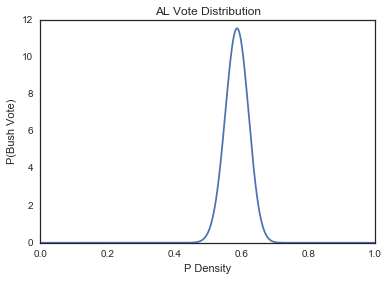

In [166]:
AL_beta = beta(119, 84)
p = np.linspace(0,1,1000)

p_density = AL_beta.pdf(p)

plt.plot(p, p_density)
plt.title('AL Vote Distribution')
plt.xlabel('P Density')
plt.ylabel('P(Bush Vote)')
plt.show()

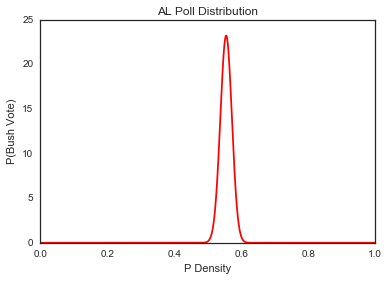

In [172]:
AL_beta = beta(464, 373)
p = np.linspace(0,1,1000)

p_density = AL_beta.pdf(p)

plt.plot(p, p_density, c='r')
plt.title('AL Poll Distribution')
plt.xlabel('P Density')
plt.ylabel('P(Bush Vote)')
plt.show()

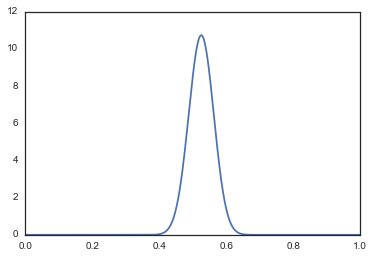

In [174]:
CO_beta = beta(95,86)
p = np.linspace(0,1,1000)

p_density = CO_beta.pdf(p)

plt.plot(p, p_density)
plt.title()

---

## 7. [BONUS] Use bootstrapping to estimate the percent of the voting distribution greater than the polling distribution

Selecting random samples from a beta distribution can be done with:

```python
from numpy.random import beta as random_beta
```

HINT: You will want to calculate the percentage of random draws from the voting distribution that are greater than all of the draws from the poll distribution.

In [5]:
from numpy.random import beta as random_beta